# Running deep learning models with BioEngine

This tutorial covers 3 models:
 * Inception model for single cell protein localization classification (by Bestfitting in the HPA single cell classification competition 2021)
 * CellPose (C Stringer et. al 2021)
 * Stardist (Weigert et. al 2020
 
Note: Please be aware that the data will be sent to a remote server (https://ai.imjoy.io/triton) running by the ImJoy team, the service is for evaluation purpose only and it is subject to change without notice. In the near future we will release the deployment toolkit so you can also run your own server easily.

In [2]:
try:
    # For pyodide in the browser
    import micropip
    await micropip.install(['pyotritonclient', 'kaibu-utils'])
except ImportError:
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'pyotritonclient', 'kaibu-utils'])

import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pyotritonclient import execute
from kaibu_utils import fetch_image

# Running CellPose cell segmentation model via the BioEngine

## Download an example image

In [3]:
image = await fetch_image('https://static.imjoy.io/img/img02.png')
image = image.astype('float32')
print("example image downloaded: ", image.shape)

example image downloaded:  (349, 467, 3)


## Make prediction with the BioEngine

In [4]:
param = {'diameter': 30, 'model_type': 'cyto'}
# run inference
results = await execute([image.transpose(2, 0, 1), param],
                              server_url='https://ai.imjoy.io/triton',
                              model_name='cellpose-python',
                              decode_bytes=True)
mask = results['mask']
print('cellpose prediction: ', mask.shape)

cellpose prediction:  (1, 349, 467)


## Display the segmentation result

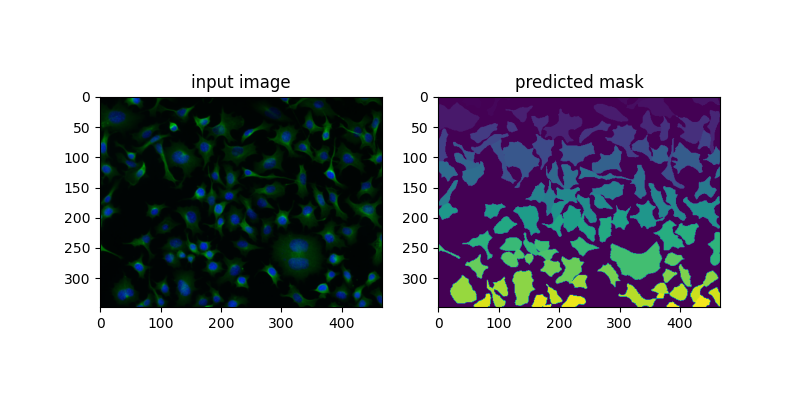

In [5]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image.astype('uint8'))
ax1.set_title('input image')
ax2.imshow(mask[0])
ax2.set_title('predicted mask')
plt.show()

# Running Stardist nuclei segmentation via the BioEngine

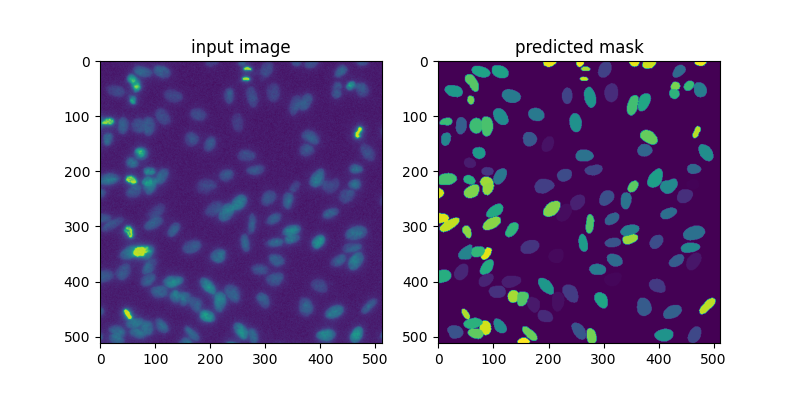

In [6]:
# obtain the model config
image = await fetch_image('https://raw.githubusercontent.com/stardist/stardist/3451a4f9e7b6dcef91b09635cc8fa78939fb0d29/stardist/data/images/img2d.tif', grayscale=True)
image = image.astype('uint16')
param = {'diameter': 30}

# run inference
results = await execute([image, param],
                              server_url='https://ai.imjoy.io/triton',
                              model_name='stardist',
                              decode_bytes=True)
mask = results['mask']

# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image)
ax1.set_title('input image')
ax2.imshow(mask)
ax2.set_title('predicted mask')
plt.show()

# Running HPA single-cell classification model via the BioEngine


## Preparation

In [7]:
LABELS = {
  0: 'Nucleoplasm',
  1: 'Nuclear membrane',
  2: 'Nucleoli',
  3: 'Nucleoli fibrillar center',
  4: 'Nuclear speckles',
  5: 'Nuclear bodies',
  6: 'Endoplasmic reticulum',
  7: 'Golgi apparatus',
  8: 'Intermediate filaments',
  9: 'Actin filaments',
  10: 'Microtubules',
  11: 'Mitotic spindle',
  12: 'Centrosome',
  13: 'Plasma membrane',
  14: 'Mitochondria',
  15: 'Aggresome',
  16: 'Cytosol',
  17: 'Vesicles and punctate cytosolic patterns',
  18: 'Negative',
}

COLORS =  ["red", "green", "blue", "yellow"]

async def fetch_hpa_image(image_id, size=None):
    crops = []
    for color in COLORS:
        image = await fetch_image(f'https://images.proteinatlas.org/{image_id}_{color}.jpg', grayscale=True, size=size)
        crops.append(image)
    image = np.stack(crops, axis=0)
    # assert image.shape == (4, 128, 128)
    return image

## Fetch an image from HPA website by its ID

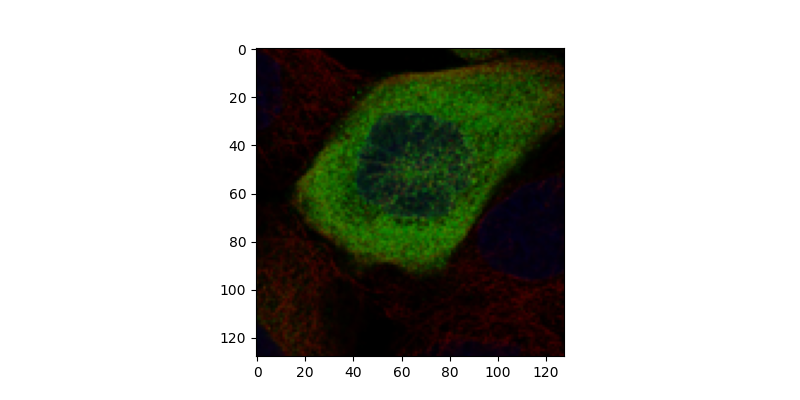

In [8]:
image = await fetch_hpa_image('115/672_E2_1', size=(340, 340))
# crop the image to a single cell
image = image[:, 60:188, 120:248]

# make sure the image size is 128x128
assert image.shape == (4, 128, 128), "please make sure the image size is 128x128"
# display the image
plt.imshow(image.transpose(1,2,0)[:,:,:3])
plt.show()

## Making prediction with the BioEngine

In [9]:
results = await execute([image.astype('float32')/255],
                        server_url='https://ai.imjoy.io/triton',
                        model_name='bestfitting-inceptionv3-single-cell')
classes = results['classes']
pred = [(LABELS[i], prob) for i, prob in enumerate(classes.tolist()) if prob>0.5]

print(f'Prediction: {pred}')

Prediction: [('Cytosol', 0.7802601456642151)]
